# Generative Modeling and Financial Time Series

### A Brief Introduction in Economy

Since the first societies in ancient Greece, it was imperative to design a system by which the society produces, distributes and consumes goods and services, which is known as *economy*. The economy involves the production, trade and consumption of goods and services by individuals, businesses and governments and can be divided into various sectors such as agriculture, industry, real estate and services. The overall health of an economy is typically measured by various economic indicators such as *gross domestic product (GDP)*, *employment rates*, *inflation rates* and *consumer confidence*. The performance of an economy can be influenced by different factors such as government policies, technological advancements, natural disasters and global events (e.g the Covid pandemic).

#### The S&P 500 Index

The S&P 500 index is a market capitalization-weighted index of 500 large-cap stocks traded on the two largest U.S. stock exchanges: the New York Stock Exchange (NYSE) and the Nasdaq Stock Market. These stocks are selected based on certain criteria such as market capitalization, liquidity, and financial viability and are representative of the U.S. economy. It is widely regarded as one of the best measures of the performance of the US equities market and it is often used as a benchmark for the overall performance of the US stock market. It was created by Standard & Poor's in 1957 and includes companies from various industries. The S&P 500 index is frequently used as a gauge of the health of the US economy and is tracked by investors, analysts and financial media around the world.

We are going to make use of this index in order to study some aspects of financial time series, as well as develop a *generative adversarial network (GAN)* that generates synthetic data that resembles the S&P 500 index. Then, we will extend this idea to the quantum computing field, where we will implement a hybrid classical-quantum *variational model* with a *parametrized quantum circuit (PQC)* as the generator of a higher-level framework known as *quantum GAN (qGAN)*,

### Financial Time Series

Economists study the functioning of economies and develop theories to explain and predict economic phenomena. Understanding the economy is important because it can affect the well-being of individuals and societies as a whole, including their standard of living, income, employment opportunities and access to goods and services. One of these theories is a mathematical framework which we refer to as *financial time series*.

A time series is generally a set of points indicating some quantity over discrete steps in time. This may include temperatures, data produced by sensors or some other value. The S&P 500 daily closing price values over a period of time is such an example. When we are dealing with finance, we call this model a financial time series.

Let us load the S&P 500 daily closing values from 1/1/2000 since 31/12/2022, using the *yfinance* module in Python which provides a more direct interface to the Yahoo Finance API and visualize the graph:

[*********************100%***********************]  1 of 1 completed
S&P500 shape (total days):  tf.Tensor([5787], shape=(1,), dtype=int32)
GPU Available: []
GPU Device: 


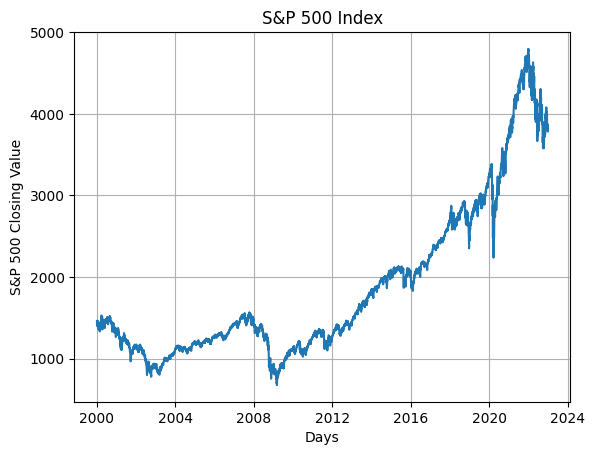

In [1]:
# hide tensorflow warnings on GPU execution (we will use CPU)
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

# disable GPU usage
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, wasserstein_distance, probplot
from scipy.special import lambertw
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
import time
import random
import tensorflow as tf
import tensorflow_probability as tfp

# limit GPU memory growth to avoid OUT_OF_MEMORY issues (before initializing GPU -- if used)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# download daily S&P 500 data from Yahoo Finance from 1/1/2000 since 31/12/2022
sp500 = yf.download('^GSPC', start='2000-01-01', end='2022-12-31')

# pandas DataFrame with 6 columns, (Open, High, Low, Close, Adj Close, and Volume values)
# extract daily closing values as a numpy array
sp500_close = tf.convert_to_tensor(sp500['Close'].values)

# display the shape of the numpy array
print('S&P500 shape (total days): ', tf.shape(sp500_close))

# check if GPU is available
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# check which GPU is being used
print("GPU Device:", tf.test.gpu_device_name())

df = sp500.reset_index()
date = df['Date']
# plot the S&P 500 data
plt.plot(date, sp500_close)
plt.xlabel('Days')
plt.ylabel('S&P 500 Closing Value')
plt.title('S&P 500 Index')
plt.grid()
plt.show()

The S&P 500 index is clearly in an uptrend over the years. This is logical, as it kind of measures the overall performance between 500 most successful companies in the U.S. It's current value is more than 8000% up from the value in the early 60s and 70s.

#### Raw price fluctuations vs Logarithmic Returns

The upward trend is a common property in many financial time series, as economies tend to grow over time, which means that the value of the index may increase over time even if there are fluctuations in the short term. Therefore, studying the index's price alone may not be sufficient to compare the index's performance over different periods of time. Instead, analysts use the *returns* instead of prices for such purposes. The *logarithmic returns* of a stock or an index is defined by the equation

$$ r_t = \ln(p_t) - \ln(p_{t-1}) = \ln \left ( \frac{p_t}{p_{t-1}} \right ) $$

where $r_t$ are the logarithmic returns at time $t$ and $p_t$ is the stock or index price at time $t$. Also, we assume that the prices are equally spaced by some constant $\Delta t$ (in our case, this is one day). For further details, refer to *'A. Chakraborti, B. Chakrabarti, S. Sinha, and A. Chatterjee, Econophysics: An Introduction, Wiley-vch, 2011'*.

The logarithmic returns have some special properties that we wish to exploit, which are not present if we used the direct returns instead, given by $p_t - p_{t-1}$. Let us visualize the direct returns and the logarithmic ones to get an idea:

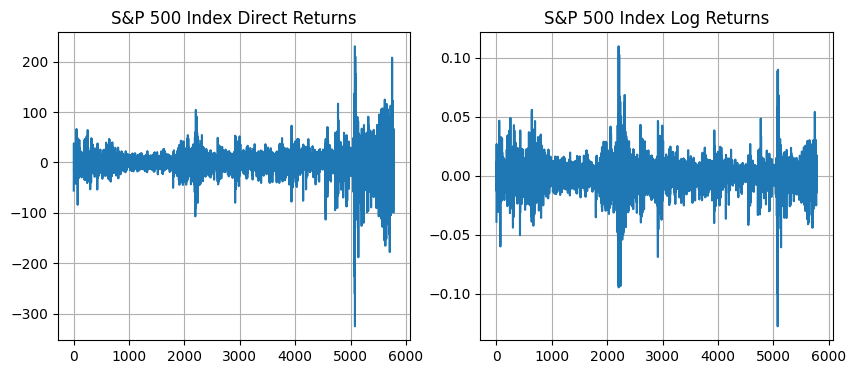

In [2]:
# direct returns over time
sp500_direct_r = sp500_close[1:] - sp500_close[:-1]
    
# logarithmic returns over time
sp500_log_r = np.log(sp500_close[1:]) - np.log(sp500_close[:-1])

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(sp500_direct_r)
axes[0].set_title('S&P 500 Index Direct Returns')
axes[0].grid()

axes[1].plot(sp500_log_r)
axes[1].set_title('S&P 500 Index Log Returns')
axes[1].grid()
    
# Show the plot
plt.show()

##### Scaling over time

The first thing to notice is how the returns scale over time. The log-returns stay within an approximate range, whereas the bounds of the direct returns range are altered. Raw price fluctuations can vary widely depending on the value of the index, which can make it difficult to compare fluctuations at different points in time. However, log-returns account for the percentage change in price, which helps to normalize the data and makes it easier to compare fluctuations across different periods. This is because of the compression that the logarithmic function induces on the values. Additionally, log-returns are additive, which means that the return over a longer period can be calculated by summing the returns over shorter periods, which is not the case with raw price fluctuations. This allows for simple arithmetic operations, such as averaging, which can be useful for various applications.

##### Returns Rate

Also, the *returns rate* $R_t$ at time $t$ is closely related to log-returns as

$$ R_t = \frac{p_t - p_{t-1}}{p_{t-1}} \approx \ln \left ( \frac{p_t}{p_{t-1}} \right ) $$

The returns rate is simply the percentage change in the value of an investment over a specific period of time. Log-returns are calculated using the natural logarithm of the ratio between the final and initial values of an investment. Since the logarithmic function is continuous and differentiable, log-returns can be interpreted as the continuously compounded returns rate. This means that a log-return of 0.01 (or 1%) can be interpreted as a continuously compounded return rate of 1%.

##### Volatility Smile

Log-returns are also related to *stock volatility*, which measures how much the price of a stock fluctuates over time. The relationship between log-returns and stock volatility is known as the *volatility smile*. It is a common feature of financial markets where implied volatility, which is derived from options prices, varies with respect to the strike price and time to expiration. In general, the volatility smile implies that log-returns are not normally distributed, but instead have fatter tails than a normal distribution would suggest. We will come to this right after.

### Stylized Empirical Facts

Over the years, analysts have extracted several statistical properties from financial time series that are present in almost every market, which are known as *stylized facts*. This is essential, as there is no standard procedure of how the values of such a series are produced. As a result, predicting future stock prices is out of the question. As a consequence of many independent empirical studies on the statistical properties of financial markets, there is a wide collection of stylized facts. We will be concerned with the most basic ones.

#### Log-Returns is not Gaussian

In order to see this, we plot the probability density function (PDF) of the log-returns along with a Gaussian distribution with the same mean and standard deviation:

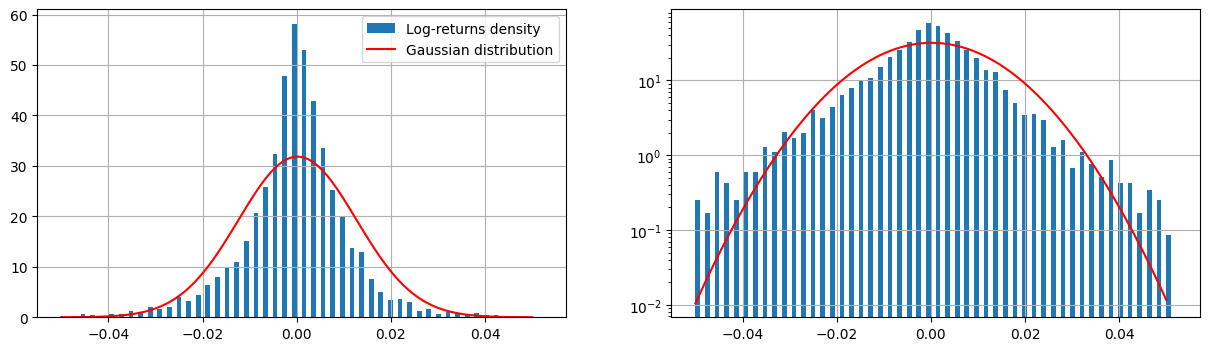

In [3]:
# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# density of log-returns
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, label='Log-returns density')
axes[0].grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_log_r)
sigma = np.std(sp500_log_r)

# Generate a set of points x
x = np.linspace(-0.05, 0.05, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes[0].plot(x, pdf, 'r', label='Gaussian distribution')
axes[0].legend()

# plot in logarithmic scale
axes[1].hist(sp500_log_r, bins=bin_edges, density=True, width=0.001, log=True)
axes[1].grid()

# plot the Gaussian PDF in logarithmic scale
axes[1].semilogy(x, pdf, 'r')

plt.show()

On the left, we have the histogram of the log-returns along with a Gaussian distribution with the same parameters and on the right, we plot the same results in logarithmic scale to inspect in further detail. The log-returns density peak is almost doubled with respect to the Gaussian distribution. Also, by inspecting the right figure, we see that the tails of the log-returns do not decay as fast as the Gaussian. This property is known as *fat tails* and shows that volatility is present more often than a Gaussian distribution would predict.

It is worth noting that these two properties are not so well clarified when we increase the time scale from days to weeks or months. This is so-called *aggregational normality*.

#### No Linear Autocorrelation

The previous observation comes from a statistical perspective and is independent of time. However, there are some stylized facts that deal with properties related to time. One such property is the absence of linear autocorrelations. We can inspect this by calculating the *autocorrelation function (ACF)* of the log-returns of the S&P 500 for a range of different lags

$$ \rho (\tau) = corr(r_t, r_{t+\tau}) = \frac{cov(r_t, r_{t+\tau})}{\sigma_{r_t} \sigma_{r_{t+\tau}}} $$

where $r_t$, $r_{t+\tau}$ are the returns, $\sigma_{r_{t}}$, $\sigma_{r_{t+\tau}}$  are the standard deviations and $cov(r_t, r_{t+\tau})$ is the covariance of the returns between times $t$ and $t+\tau$, where $\tau$ is the lag. Since we have daily timeframe, $\tau \in \mathbb{N}^*$.

We calculate the autocorrelations of the log-returns at a range of lags $\tau \in \{1,\dots,30\}$, so the maximum lag is 30 days.

In [4]:
# convert the S&P 500 log returns to a TensorFlow tensor
sp500_log_r_tf = tf.convert_to_tensor(sp500_log_r)

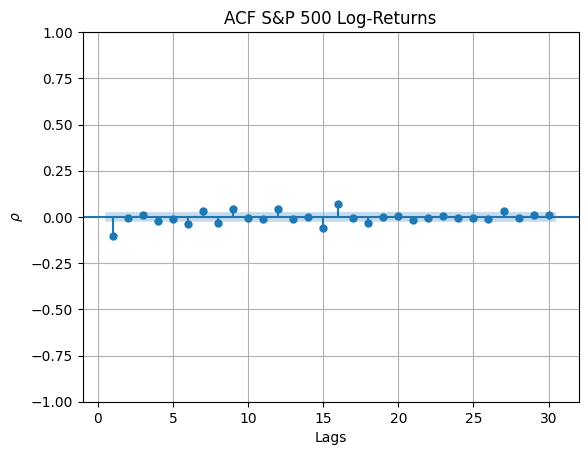

In [5]:
# plot the ACF for the specified lags
tsaplots.plot_acf(sp500_log_r_tf, lags=30, zero=False)
plt.xlabel('Lags')
plt.title('ACF S&P 500 Log-Returns')
plt.ylabel(r'$\rho$')
plt.grid()
plt.show()

As we can see, the values are very close to zero, so there is no sufficient autocorrelation. In an efficient market, stock prices are believed to reflect all known information about the market, which means that any new information that becomes available will be quickly incorporated into the stock price. As a result, there should be no predictable pattern of price movements over time and the autocorrelation of the stock returns should be close to zero. This is because, if investors are rational and acting on all available information, the current stock price should reflect the expected future value of the stock and any deviation from that expected value would be quickly corrected as new information becomes available. Therefore, the absence of autocorrelation is actually to be expected in an efficient market, since the current price already incorporates all available information and there should be no predictable pattern of price movements over time. Also, as lags are getting higher, autocorrelation decreases.

#### Volatility Clustering

Volatility clustering is a phenomenon in financial markets where periods of high volatility tend to be followed by other periods of high volatility and periods of low volatility tend to be followed by other periods of low volatility. This means that volatility tends to cluster together in time, rather than being randomly distributed.

We can get an intuitive understanding of volatility clustering by looking at the log-returns. However, we wish to quantify this phenomenon. Specifically, we can do this by looking at the autocorrelation function ACF of the *absolute log-returns* $\left | r_t \right |$ and $\left | r_{t+\tau} \right |$ over a range of lags $\tau$ defined by

$$ \rho_{abs} (\tau) = corr(\left | r_t \right |, \left | r_{t+\tau} \right |) $$

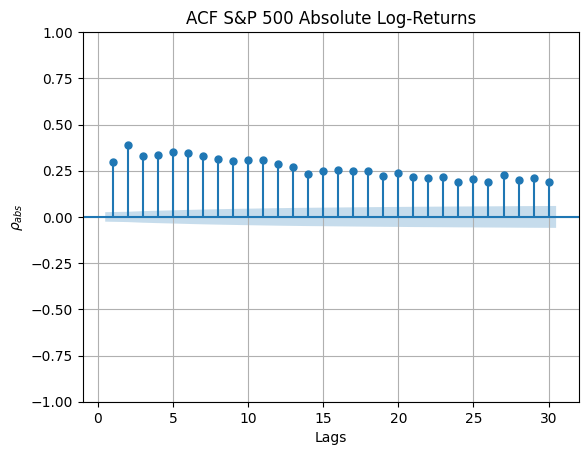

In [6]:
# plot the ACF of absolute log-returns for the specified lags
tsaplots.plot_acf(tf.abs(sp500_log_r_tf), lags=30, zero=False)
plt.xlabel('Lags')
plt.title('ACF S&P 500 Absolute Log-Returns')
plt.ylabel(r'$\rho_{abs}$')
plt.grid()
plt.show()

The presence of significant autocorrelation for absolute log-returns is an indication that there are patterns in the data that are related to the magnitude of price changes and that these patterns can be characterized by volatility clustering. Also, autocorrelation decreases as the lag is increased. This is expected in efficient markets. This plot provides insights into the persistence of volatility over time in the financial time series.

#### The Leverage Effect

But, how the returns are correlated to volatility ? The *leverage effect* is a stylized fact that deals with this and is commonly present in financial time series. It is given by

$$ L(\tau) = corr \left(r_{t+\tau}^2, r_t\right) $$

where $r_{t+\tau}^2$ is another widely used metric for volatility.

Let us calculate and inspect the leverage effect:

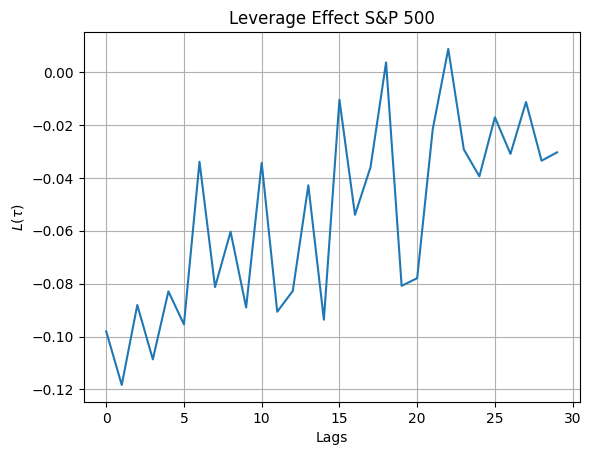

In [7]:
lags = range(1, 31)
lev = []
for lag in lags:
    # slice the tensors to get the appropriate lagged sequences
    r_t = sp500_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(sp500_log_r_tf[lag:]))
                
    # calculate the leverage effect
    lev.append(tfp.stats.correlation(r_t, squared_lag_r, sample_axis=0, event_axis=None))

# plot the the levarage effect
plt.plot(lev)
plt.title('Leverage Effect S&P 500')
plt.xlabel('Lags')
plt.ylabel(r'$L(\tau)$')
plt.grid()
plt.show()

As the lag increases, the leverage effect goes to 0, starting from a lower negative value. The returns are *negatively correlated* to price volatility. Specifically, it means that as the price of an asset falls, the volatility of that asset tends to increase and vice versa. This implies that when the market is experiencing negative returns, the volatility of that market tends to increase.

The reason for the leverage effect is due to the presence of financial leverage, which refers to the use of borrowed funds to invest in assets. When investors use leverage to buy an asset, they increase the risk of their investment since they have to pay back the borrowed funds regardless of the performance of the asset. If the asset performs poorly, then the investor may be forced to sell at a loss to pay back the borrowed funds, which can further amplify the downward price movement and increase the volatility of the asset.

### Generative Modeling: Application in Financial Time Series

Generative modeling deals with generation of synthetic data that closely resemble some other data. It is a form of unsupervised learning where the model at hand is trained to capture the underlying statistics and learn the properties of some dataset. There are several techniques (e.g restricted Boltzmann machines, Deep-Belief networks, GANs) involved for various appications, such as image generation, data augmentation, feature extraction, style transfer and text inference among others. We will look at the promising method of generative adversarial networks (GANs). The general high-level architecture of a GAN is shown below (Source: Google):

<img src="./images/gan.png" width="60%" align="center">

Briefly explained, GANs include two neural networks called the *generator* and *discriminator* respectively. These two networks compete in a *zero-sum game*. In each training round, the discriminator is trained first on a batch of real data and then on a batch of synthetic data that the generator produced, given random noise as input. The discriminator penalizes the generator for not producing synthetic data that is close to the real data via feedback and tries to minimize the generator error. Then, the generator is trained on random noise and based on the feedback of the discriminator, it tries to generate data that closely resemble the real ones by maximizing the discriminator's error. The models are tained consequtively and independently. In an ideal case where the generator produces perfect replicas of the data, the discriminator loss lies to 50%, as it is not able to distinguish between real and fake data. This competitive training continues until the model has adequate performance. The latter is closely related to the task at hand.

The most common GAN architectures used for time series data include LSTM-GANs and WGANs.

It's important to acknowledge the limitations of generative modeling in financial time series. Generating realistic financial data can be challenging due to the complex and dynamic nature of financial markets. The generated samples may not fully capture the intricacies of real-world financial data and caution should be exercised when using generated data for decision-making or risk management purposes.

#### LSTM-GANs
LSTM-GANs utilize a type of neural network called a *Long Short-Term Memory (LSTM)* network, which is a type of *recurrent neural network (RNN)* that can remember past inputs and use that information to inform future predictions. In an LSTM-GAN, the generator is an LSTM network that takes as input a randomly generated noise vector and produces a sequence of synthetic financial time series data. The discriminator is also an LSTM network that takes as input a sequence of either real or synthetic financial time series data and outputs a probability indicating whether the input data is real or synthetic.

#### WGANs
WGANs use a different type of loss function called the *Wasserstein distance*, which measures the distance between two probability distributions. In a WGAN, the generator produces synthetic financial time series data and the discriminator outputs a scalar value representing the probability that a given sequence of financial time series data is real or synthetic. The WGAN training process involves minimizing the Wasserstein distance between the probability distributions of the real and synthetic financial time series data. This is a variant of the GAN framework.

The Wasserstein distance, also known as Earth Mover’s Distance (EMD) is a ***quantitative metric*** that allows the comparison of two distributions that two different datasets follow, without assuming any underlying distribution. Assume that the reference distribution is denoted by $P$ and the model distribution by $Q$. As we are interested with one-dimensional data, we use the so-called Wasserstein-1 distance defined by

$$ W_1 (P,Q) = \int_{-\infty}^{\infty} \left | F_P (x) - F_Q (x) \right | dx $$,

where $F_P(x)$ and $F_Q(x)$ are the cumulative distribution functions of $P$ and $Q$ respectively and $x$ denotes the samples. This needs a numerical method in order to be computed. It can be found in the Python *SciPy* library, built on top of *Numpy*, which is widely used for scientific and technical computing.

##### WGAN with Gradient Penalty (WGAN-GP)
The key difference between WGAN and other GAN variants is the use of a *critic* instead of a discriminator. The critic is trained to output a real number rather than a probability and is optimized to minimize the Wasserstein distance between the real and generated distributions. The WGAN with gradient penalty (WGAN-GP) is an improved version of the original WGAN that introduces a gradient penalty term to the critic's loss function. In the WGAN-GP, the critic is penalized when its gradient norm deviates from 1, which is the desired value for a Lipschitz continuous function. This is achieved by computing the gradient penalty as the squared difference between the norm of the critic's gradient and 1 and adding it to the original Wasserstein distance objective. If we assume that the output of the critic is denoted by $C(x)$, where $x$ is a sample, the critic's loss function becomes

$$ W_1' (P,Q) = \int_{-\infty}^{\infty} \left | F_P (x) - F_Q (x) \right | dx + \left ( \| \nabla_x C \| - 1 \right )^2 $$

This encourages the critic to have a gradient norm close to 1 everywhere, which in turn enforces the Lipschitz continuity constraint and leads to more stable training and improved sample quality. Also, it helps avoid the problem of vanishing gradients and mode collapse. The magnitude of the gradient penalty is controlled by a hyperparameter called the penalty coefficient, which determines the strength of the penalty relative to the original Wasserstein distance objective.

This is the type of GAN we will implement.

##### Kullback-Liebler Divergence vs Wasserstein Distance
As we know, the *Kullback-Leibler (KL) divergence* is a measure of how one probability distribution diverges from a second, reference probability distribution. It is a common loss function used in generative models and one may notice the similarity with the Wasserstein distance. However, when used in GANs, KL divergence can suffer from the problem of *vanishing gradients*, where the gradients become too small to make meaningful updates to the generator network. This is mainly due to the logarithmic function. Also, it can lead to mode collapse, where the generator produces only a few modes of the true data distribution and ignoring the rest. This is because KL divergence penalizes the generator if it generates samples that are far from the true distribution, but it does not provide any reward for generating samples that are different from the ones already generated.

On the other hand, Wasserstein distance can be more stable during training, as it avoids the problem of vanishing gradients that can affect the KL divergence. It has been shown to be effective at reducing mode collapse, producing more diverse samples from the generator. The Wasserstein distance can be interpreted as a measure of how much work (in terms of distance multiplied by probability mass) is needed to transform one distribution into another, providing a useful metric of the difference between the true and generated data distributions. A disadvantage is that it can be computationally expensive to calculate, requiring the use of specialized optimization algorithms such as the *earth-mover's distance (EMD)* or *Sinkhorn distance*. Also, it can be sensitive to the choice of distance metric used to calculate it and it can be difficult to choose an appropriate metric for a given problem.

For further details on WGANs, refer to Arjovsky's et. al *'Wasserstein GAN'*: https://arxiv.org/abs/1701.07875, (2017).

### Model Performance

When dealing with WGANs for financial time series, one should carefully consider what metrics will define the model performance. The generated synthetic data must be close to the original data and should be able to replicate the stylized facts we talked about earlier:
 - The log-returns do not follow a Gaussian distribution
 - The absence of autocorrelation
 - Volatility clustering
 - Leverage Effect
 
##### Q-Q Plot
The metrics above offer a ***qualitative criterion*** of the model performance. However, we will also need a proper way to compare the underlying distributions of the generated data and the S&P 500 log-returns data in order to get another qualitative metric which will enhance model evaluation along with the histograms. For this purpose, we will use a visualization technique called *Q-Q plot* which gives the ability of better inspection of the specific areas of the distribution where the two distributions differ.

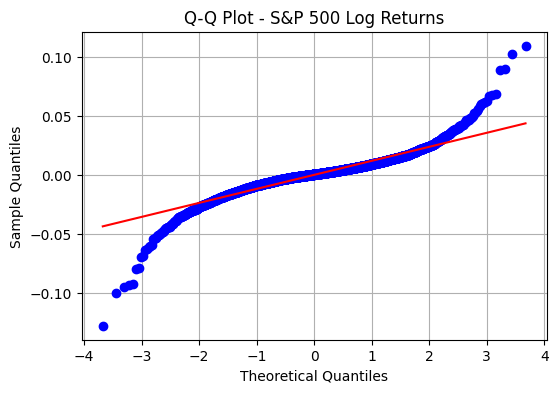

In [8]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(sp500_log_r_tf, dist='norm', plot=plt)
plt.title('Q-Q Plot - S&P 500 Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

##### Monitoring the Training process
Apart from the qualitative metrics, we also need metrics of the ***quantitative*** kind in order to be able to compare different models with different parameters, as well as monitor the training process. The first one was introduced earlier as the Wasserstein-1 distance or EMD. Also, we need a way to quantify the stylized facts that depend on the timeframe. The *root mean squared error (RMSE)* is a frequently used measure of the differences between values, so we will exploit this.

For the autocorrelation of the log-returns, we can define the following cost function

$$\text{RMSE}(\rho^{S\&P}(\tau), \rho^{\theta}(\tau)) = \left ( \frac{1}{\tau_{max}} \sum_{\tau = 1}^{\tau_{max}} \left (\rho^{S\&P}(\tau) - \rho^{\theta}(\tau) \right )^2 \right )^{\frac{1}{2}}$$
where $\rho^{S\&P}(\tau)$ is the ACF of the log-returns of the S\&P 500, $\rho^{\theta,i}(\tau) $ is the ACF of the log-returns of the generated data of the model with parameters $\theta$ and the others are implied.

With the same approach, we can define a cost function for the absolute log-returns (volatility clustering) as

$$ \text{RMSE}(\rho^{S\&P} _{abs}(\tau), \rho^{\theta} _{abs}(\tau)) = \left ( \frac{1}{\tau_{max}} \sum_{\tau = 1}^{\tau_{max}} \left (\rho^{S\&P} _{abs}(\tau) - \rho^{\theta} _{abs}(\tau) \right )^2 \right )^{\frac{1}{2}} $$

where $\rho^{S\&P} _{abs}(\tau)$ is the ACF of the absolute log-returns of the original data and $\rho^{\theta} _{abs}(\tau)$ is the ACF of the absolute log-returns of the generated data from the model with parameters $\theta$.

Last, we define a cost function for the leverage effect as

$$ \text{RMSE}(L^{S\&P}(\tau), L^{\theta}(\tau)) = \left ( \frac{1}{\tau_{max}} \sum_{\tau = 1}^{\tau_{max}} \left (L^{S\&P}(\tau) - L^{\theta}(\tau) \right )^2 \right )^{\frac{1}{2}} $$

where the variables are implied.

Note that when we calculate cost functions when training neural networks, it is a common practice to evaluate the result over multiple samples. So, we should bear in mind to calculate the costs above over multiple generated time series.

### Model Implementation

The design of the WGAN with gradient penalty is based on *'Improved Training of Wasserstein GANs'* from *Ishaan Gulrajani* et.al: https://arxiv.org/abs/1704.00028

### Data Pre-processing

#### (1) Normalization

Now that we have all the information we need, we move to the design of the WGAN-GP. First, we will do some preprocessing on the financial time series data that we have (S&P 500).

Let us normalize the data to have zero mean and unit variance. This helps the network learn more effectively by putting all features on a similar scale. It is a common standardization technique used in machine learning models. We can do this by the equation below

$$ r_t ^{\text{norm}} = \frac{r_t - \mu}{\sigma} $$

where $r_t ^{\text{norm}}$ is the normalized log-returns, $r_t$ the original log-returns, $\mu$ and $\sigma$ the mean and standard deviation of $r_t$ respectively.

In [9]:
def normalize(data):
    mu = tf.reduce_mean(data)
    std = tf.math.reduce_std(data)
    
    return (data - mu)/std

In [10]:
# normalize the log-returns
sp500_norm_r = normalize(sp500_log_r_tf)
# display the mean and standard deviation of the original log-returns
print(f'Original S&P 500 log-returns mean = {tf.reduce_mean(sp500_log_r_tf)}, std = {tf.math.reduce_std(sp500_log_r_tf)}')
# display the mean and standard deviation of the normalized log-returns
print(f'Normalized S&P 500 log-returns mean = {tf.reduce_mean(sp500_norm_r)}, std = {tf.math.reduce_std(sp500_norm_r)}')

Original S&P 500 log-returns mean = 0.00016767802937748248, std = 0.012526267224199528
Normalized S&P 500 log-returns mean = -7.368227470723472e-18, std = 0.9999999999999999


In [11]:
print('Original Data Min-Max')
print(tf.reduce_min(sp500_log_r_tf).numpy(), tf.reduce_max(sp500_log_r_tf).numpy())

print('Normalized Data Min-Max')
print(tf.reduce_min(sp500_norm_r).numpy(), tf.reduce_max(sp500_norm_r).numpy())

Original Data Min-Max
-0.12765219747281709 0.10957196759533883
Normalized Data Min-Max
-10.20414727024656 8.733989751919305


In [12]:
def denormalize(norm_data, mu_original, std_original):
    return norm_data*std_original + mu_original

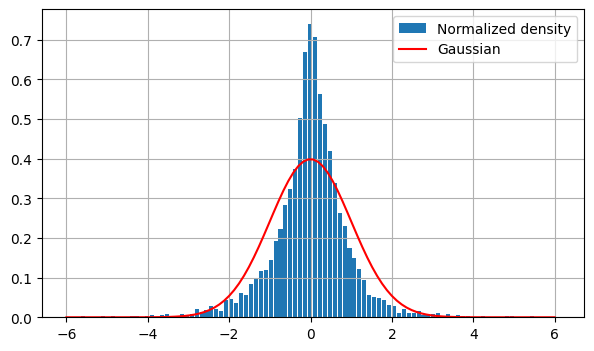

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(sp500_norm_r, bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_norm_r)
sigma = np.std(sp500_norm_r)

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

#### (2) Inverse Lambert W Transform

Given the limited number of samples in the tails, learning a heavy-tailed distribution can be difficult. To address this challenge, we can employ a method to decrease the influence of these tails. One approach involves applying an inverse Lambert-W transform to the normalized log returns. By applying this transformation, we can convert the heavy-tailed data into a distribution that closely resembles a Gaussian distribution. This can be advantageous for further analysis or modeling tasks that assume Gaussianity.

Given Lambert's W function which is the inverse of $ z = u e^u$ with $z : \mathbb{R} \rightarrow \mathbb{R}$, we can define the following transform to our normalized heavy-tailed data set $V$ as

$$ W_{\delta}(v) = sgn(v) \sqrt{\frac{W(\delta v^2)}{\delta}} $$

where $v \in V$, $\delta \geq 0$ a tunable parameter and $sgn(v)$ the sign of $v$ and $W$ the Lambert function.

The Gaussianized data can be transformed back to its original state using the equation

$$ v = W_{\delta}(v) \exp \left ( \frac{\delta}{2} W^2 _{\delta}(v) \right ) $$

In [14]:
def inverse_lambert_w_transform(data, delta):
    """
    Apply inverse Lambert W transform to the input data using the specified delta value.

    Parameters:
    - data: Input data tensor
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Transformed data array
    """
    sign = tf.sign(tf.cast(data, dtype=tf.float64))  
    transformed_data = sign * tf.cast(tf.sqrt(lambertw(delta * data ** 2).real / delta), dtype=tf.float64)
    
    return transformed_data

def lambert_w_transform(transformed_data, delta, clip_low=-12.0, clip_high=11.0):
    """
    Transform the Gaussianized data back to its original state.

    Parameters:
    - transformed_data: Input data array which was transformed using inverse Lambert W
    - delta: Delta value for the transform (tail parameter)

    Returns:
    - Original Data
    """
    reversed_data = transformed_data*tf.cast(tf.exp((delta/2) * transformed_data ** 2), dtype=tf.float64)
    return tf.clip_by_value(reversed_data, clip_low, clip_high)

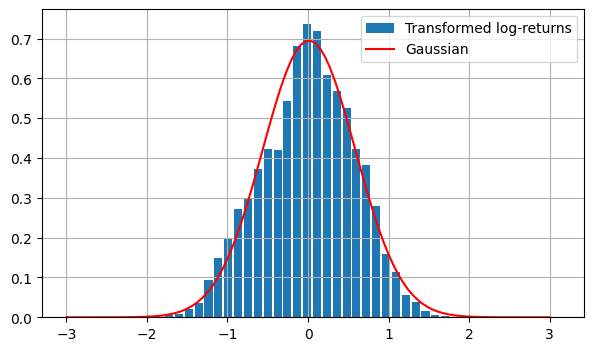

In [15]:
# apply inverse Lambert W transform to the normalized log-returns
transformed_sp500 = inverse_lambert_w_transform(sp500_norm_r, 1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(transformed_sp500, bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(transformed_sp500)
sigma = np.std(transformed_sp500)

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

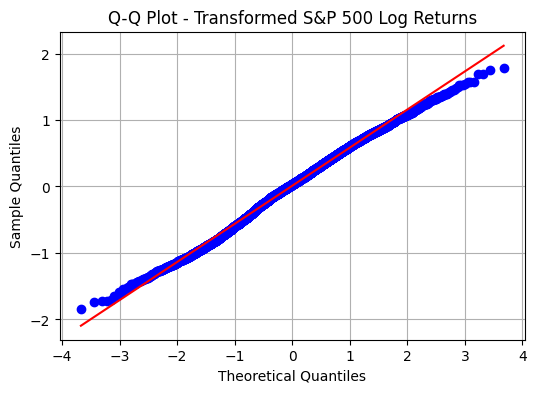

In [16]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_sp500, dist='norm', plot=plt)
plt.title('Q-Q Plot - Transformed S&P 500 Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

In [17]:
print('Transformed Data Min-Max')
print(tf.reduce_min(transformed_sp500).numpy(), tf.reduce_max(transformed_sp500).numpy())

Transformed Data Min-Max
-1.8484763999547917 1.7827356569487114


In [18]:
print('Transformed data mean: ', tf.reduce_mean(transformed_sp500).numpy())
print('Transformed data std: ', tf.math.reduce_std(transformed_sp500).numpy())

Transformed data mean:  0.011617891256075227
Transformed data std:  0.5739083944257461


It is clear that our transformed data matches a normal distribution quite well.

#### (3) Normalization

In [19]:
# normalize the transformed data
transformed_sp500_norm = normalize(transformed_sp500)
print(f'Normalized Transformed log-returns mean = {tf.reduce_mean(transformed_sp500_norm)}, std = {tf.math.reduce_std(transformed_sp500_norm)}')

Normalized Transformed log-returns mean = 1.2280379117872454e-17, std = 0.9999999999999998


In [20]:
print('Normalized Transformed Data Min-Max')
print(tf.reduce_min(transformed_sp500_norm).numpy(), tf.reduce_max(transformed_sp500_norm).numpy())

Normalized Transformed Data Min-Max
-3.241099641123181 3.0860635301646355


### Check Reverse Process

#### (3) Denormalize

In [21]:
# denormalize the transformed data
transformed_sp500_denorm = denormalize(transformed_sp500_norm, tf.reduce_mean(transformed_sp500), tf.math.reduce_std(transformed_sp500))
print('Transformed (denormalized) data mean: ', tf.reduce_mean(transformed_sp500_denorm).numpy())
print('Transformed (denormalized) data std: ', tf.math.reduce_std(transformed_sp500_denorm).numpy())

Transformed (denormalized) data mean:  0.011617891256075227
Transformed (denormalized) data std:  0.5739083944257461


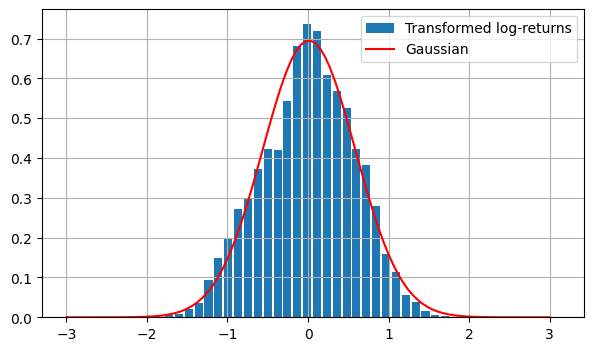

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of normalized log-returns
bin_edges = np.linspace(-3, 3, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(transformed_sp500_denorm, bins=bin_edges, density=True, width=0.1, label='Transformed log-returns')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(transformed_sp500_denorm)
sigma = np.std(transformed_sp500_denorm)

# Generate a set of points x
x = np.linspace(-3, 3, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the normalized log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

#### (2) Lambert W Transform

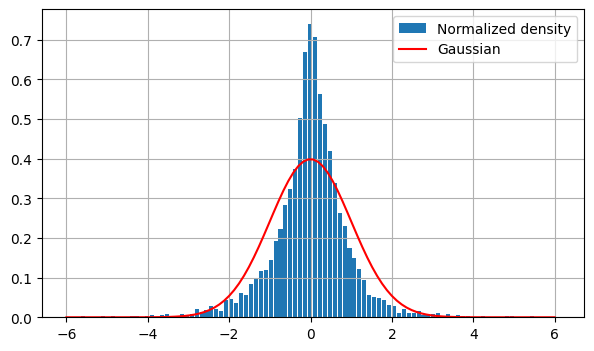

In [23]:
sp500_norm_r_reversed = lambert_w_transform(transformed_sp500_denorm, 1)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7,4))

# density of log-returns
bin_edges = np.linspace(-6, 6, num=100)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes.hist(sp500_norm_r_reversed, bins=bin_edges, density=True, width=0.1, label='Normalized density')
axes.grid()

# normal distribution with same mean and standard deviation as log-returns
mu = np.mean(sp500_norm_r_reversed)
sigma = np.std(sp500_norm_r_reversed)

# Generate a set of points x
x = np.linspace(-6, 6, 100)

# Generate the Gaussian PDF for the points x with same mean and standard deviation as the log-returns
pdf = norm.pdf(x, mu, sigma)

# plot the Gaussian PDF
axes.plot(x, pdf, 'r', label='Gaussian')
axes.legend()

plt.show()

In [24]:
print('Denormalized data mean: ', tf.reduce_mean(sp500_norm_r_reversed).numpy())
print('Denormalized data std: ', tf.math.reduce_std(sp500_norm_r_reversed).numpy())

Denormalized data mean:  -7.368227470723472e-18
Denormalized data std:  0.9999999999999999


In [25]:
print('Denormalized Data Min-Max')
print(tf.reduce_min(sp500_norm_r_reversed).numpy(), tf.reduce_max(sp500_norm_r_reversed).numpy())

Denormalized Data Min-Max
-10.20414727024656 8.733989751919305


#### (1) Denormalize

In [26]:
# denormalize the initial data
transformed_sp500_denorm = denormalize(sp500_norm_r_reversed, tf.reduce_mean(sp500_log_r_tf), tf.math.reduce_std(sp500_log_r_tf))
print('Original (denormalized) data mean: ', tf.reduce_mean(transformed_sp500_denorm).numpy())
print('Original (denormalized) data std: ', tf.math.reduce_std(transformed_sp500_denorm).numpy())

Original (denormalized) data mean:  0.00016767802937748248
Original (denormalized) data std:  0.012526267224199528


In [27]:
print('Original Data Min-Max')
print(tf.reduce_min(transformed_sp500_denorm).numpy(), tf.reduce_max(transformed_sp500_denorm).numpy())

Original Data Min-Max
-0.12765219747281709 0.10957196759533883


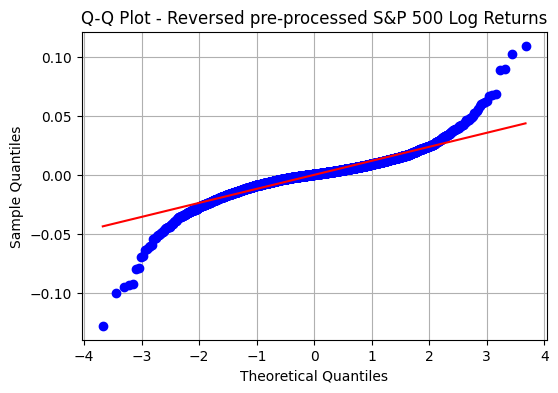

In [28]:
# Generate the Q-Q plot
plt.figure(figsize=(6, 4))
probplot(transformed_sp500_denorm, dist='norm', plot=plt)
plt.title('Q-Q Plot - Reversed pre-processed S&P 500 Log Returns')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

The reverse process works as expected. We can now move on to applying the rolling window technique.

#### (4) Rolling Window

The rolling window technique is commonly used in time series analysis to generate multiple subsequences from a given time series. It involves defining a window of length $m$ and a stride $s$. The window length determines the size of each subsequence, while the stride determines the distance between the start of one subsequence and the start of the next. By applying the rolling window with the specified window length and stride to the time series, we obtain a set of subsequences each of which can be treated as a new sample in our dataset. If we assume that there are $n$ total samples, then after applying the rolling window we get $ \lfloor{\frac{n-m}{s}}\rfloor + 1 $ samples, which will be fed to the model at each training epoch.


As we may notice, there is often overlap between adjacent subsequences due to the stride being shorter than the window length. This can lead to correlation between training samples, which is not ideal. However, the larger number of training samples generated by the rolling window technique can be beneficial for model performance, as it provides more data for the model to learn from.

The following function implements a rolling window to the one-dimensional input data and returns a dataset (tensor) of $ \lfloor{\frac{n-m}{s}}\rfloor + 1 $ rows and $m$ columns:

In [29]:
def rolling_window(data, m, s):
    return tf.map_fn(lambda i: data[i:i+m], tf.range(0, len(data) - m + 1, s), dtype=tf.float64)

### Critic & Generator Models

#### Critic Model

Research has been conducted on how the critic should be efficiently implemented in a WGAN-GP and it has been shown that *convolutional neural networks (CNNs)* with one-dimensional convolutional layers are able to produce financial time series with stylized facts, rather than using a simple feed-forward network. For further details, refer to Chapter 3 of this thesis: *Schwander, E. (2022). Quantum generative modelling for financial time series*, which is further based in *'Improved Training of Wasserstein GANs'* from *Ishaan Gulrajani* et.al: https://arxiv.org/abs/1704.00028

So, we will follow this approach as our main concern is not the design of a classical generative model for financial time series, but a hybrid variation using quantum computation.

In this implementation, we define a function that takes a window length as input and returns the critic model. The model has three 1D convolutional layers with 64, 128, and 128 filters respectively. Each convolutional layer has a kernel size of 3 and a stride of 1 and is followed by a leakyReLU activation function with an alpha value of 0.01. In a CNN architecture, the convolutional layers are typically followed by one or more dense layers to process the extracted features and make predictions. The Flatten layer is to reshape the output of the convolutional layers into a 1-dimensional tensor, which is then fed into a dense layer of 32 neurons and leakyReLu activation and a dropout layer with a rate of 0.2 for introducing better generalization. The final layer is a dense layer with a single output, which is linear. Note that one should not confuse the 'strides' in this code with the window stride, as the first determines the step size of the sliding window in the convolution operation.

#### Generator Model

Here, we also define a simple feedforward neural network using the Sequential API of TensorFlow. The *latent_dim* is the dimensionality of the input noise vector that will be used to generate fake samples.

A linear activation for the generator output is reasonable, as the critic gives feedback based on the preprocessed samples. This means that the generator tries to capture properties from the preprocessed data, hence for proper evaluation, the generator's output should be processed in a reverse manner to form the original log-returns.

### The WGAN-GP

The WGAN-GP model is designed based on *I. Gulrajani, F. Ahmed, M. Arjovsky, V. Dumoulin, and A. C. Courville,
Improved Training of Wasserstein GANs*. In contrast to the original GAN formulation, the authors have made some adjustments. 

 - During each WGAN training iteration, the generator is updated once for every *n_critic* updates of the critic, where *n_critic* is a hyperparameter that determines how many times the critic is trained before the generator is updated. This is to ensure that the critic is able to distinguish real samples from generated samples with high confidence and that it is able to provide meaningful feedback to the generator. This is important because the generator's updates are based on the critic's feedback, so if the critic is not properly trained, the generator's updates may not be effective.
 - Interpolation is used to encourage the generated samples to lie along the straight line between the real and generated samples. By computing the interpolated samples as a convex combination of the real and generated samples using a uniform random epsilon value, the generator is encouraged to produce samples that are more similar to the real samples and lie along the data distribution manifold. This helps to avoid the problem of gradient vanishing and gradient explosion that can occur during training when the gradient of the critic with respect to the generator becomes zero or infinite respectively.
 - The authors propose a different loss function for the generator called the "negative critic loss" or "minimax loss" instead of the binary cross-entropy loss used in traditional GANs. The idea is to maximize the critic's output for fake samples, which is equivalent to minimizing the negative critic loss. This is different from traditional GANs, where the generator tries to maximize the log probability of the discriminator being wrong.

In [30]:
class WGAN_GP(tf.keras.Model):
    def __init__(self, num_epochs, batch_size, latent_dim, window_size, n_critic, gp):
        super(WGAN_GP, self).__init__()
        # define the critic and generator networks
        self.critic = self.define_critic_model(window_size)
        self.generator = self.define_generator_model(latent_dim, window_size)
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.window_size = window_size
        self.n_critic = n_critic
        self.gp = gp
        # average critic and generator losses for each epoch
        self.critic_loss_avg = []
        self.generator_loss_avg = []
        # Earth's mover distance (EMD) for each epoch
        self.emd_avg = []
        # stylized facts RMSEs for each epoch
        self.acf_avg = []
        self.vol_avg = []
        self.lev_avg = []
        
    def define_critic_model(self, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=10, strides=1, input_shape=(window_length, 1), padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=10, strides=1, padding='same'))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
    
        model.add(tf.keras.layers.Flatten())
    
        model.add(tf.keras.layers.Dense(32, dtype=tf.float64))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))
    
        model.add(tf.keras.layers.Dense(1, dtype=tf.float64))

        return model
    
    def define_generator_model(self, latent_dim, window_length):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Dense(30, input_shape=(latent_dim,)))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))

        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))
              
        model.add(tf.keras.layers.Dense(50))
        model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
        model.add(tf.keras.layers.Dropout(0.2))
    
        model.add(tf.keras.layers.Dense(window_length, dtype=tf.float64))
    
        return model
    
    # compile model with given optimizers for critic and generator networks
    def compile_WGAN(self, c_optimizer, g_optimizer):
        super(WGAN_GP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
    
    def train_wgan_gp(self, gan_data, original_data, preprocessed_data, num_elements):
        """
        Parameters:
         - gan_data is the preprocessed dataset with windows for WGAN training
         - original_data is the original S&P 500 log-returns for evaluation of RMSEs (monitoring purposes)
         - preprocessed_data is the preprocessed log-returns without the last normalization step and without windows
          (for reversing the process of generated samples using the mean and std and evaluating the RMSEs)
        """
        for epoch in range(self.num_epochs):
            print(f'Processing epoch {epoch+1}/{self.num_epochs}')
            ################################################################
            #
            # Train the critic for n_critic iterations
            # Process 'batch_size' samples in each iteration independently
            #
            ################################################################
            # critic loss for 'n_critic' iterations
            critic_t_sum = 0
            for t in range(self.n_critic):
                # record the gradients
                with tf.GradientTape() as critic_tape:
                    # critic loss for 'batch_size' samples
                    critic_sum = 0
                    for i in range(self.batch_size):
                        # shuffle the dataset
                        shuffled_data = gan_data.shuffle(buffer_size=num_elements)
                        # take a single random element from the shuffled dataset
                        random_element = shuffled_data.take(1)
                        # iterate over the random_element dataset to access the value
                        for element in random_element:
                            # access the value of the random element as a tensor
                            real_sample = element
                        # reshape the real sample for compatibility with the first layer of the critic
                        real_sample = tf.reshape(real_sample, (1, self.window_size))
                    
                        # generate latent noise for the generator
                        latent_noise = tf.random.normal(shape=(1, self.latent_dim))
                   
                        # generate fake samples using the generator
                        generated_sample = self.generator(latent_noise)
                        
                        # calculate the critic scores for real and fake samples
                        real_score = self.critic(real_sample)
                        fake_score = self.critic(generated_sample)
                     
                        # compute the gradient penalty
                        gradient_penalty = self.compute_gradient_penalty(real_sample, generated_sample)

                        # calculate the Wasserstein distance loss with gradient penalty
                        critic_loss = fake_score - real_score + self.gp * gradient_penalty
                        # accumulate the critic loss for the sample
                        critic_sum += critic_loss

                    # compute the gradients of critic and apply them
                    critic_gradients = critic_tape.gradient(critic_sum/self.batch_size, self.critic.trainable_variables)
                    self.c_optimizer.apply_gradients(zip(critic_gradients, self.critic.trainable_variables))
                    
                # accumulate the average critic loss for all samples in this 't' iteration
                critic_t_sum += critic_sum/self.batch_size
            
            # average critic loss for this epoch of WGAN training
            self.critic_loss_avg.append(critic_t_sum/self.n_critic)
            
            ################################################################
            #
            # Train generator for one iteration
            #
            ################################################################
            # sample a batch of latent variables
            latent_noise = tf.random.normal(shape=(self.batch_size, self.latent_dim))
            with tf.GradientTape() as gen_tape:
                # generate fake samples using the generator
                generated_samples = self.generator(latent_noise)
                # calculate the critic scores for fake samples
                fake_scores = self.critic(generated_samples)
                # calculate the generator loss
                generator_loss = -tf.reduce_mean(fake_scores)

            # compute the gradients of generator and apply them
            generator_gradients = gen_tape.gradient(generator_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(generator_gradients, self.generator.trainable_variables))
            
            # average generator loss for this epoch
            self.generator_loss_avg.append(generator_loss)
            
            #######################################################################################################
            #
            # Calculate the stylized facts RMSEs and the EMD for real and fake data
            # 
            # Fake data has shape (num_samples x window_size), where num_samples = original_length / window_size
            # in order to get a time series close to the length of the original
            #
            #######################################################################################################
            # generate noise
            num_samples = len(original_data) // self.window_size
            latent_noise = tf.random.normal(shape=(num_samples, self.latent_dim))
            # generate fake samples using the generator
            batch_generated = self.generator.predict(latent_noise, verbose=0)
            # concatenate all time series data into one
            generated_data = tf.reshape(batch_generated, shape=(num_samples*self.window_size,))
            
            # reverse the preprocessing on generated sample
            transformed_sp500_denorm = denormalize(generated_data, tf.reduce_mean(preprocessed_data), tf.math.reduce_std(preprocessed_data))
            original_norm = lambert_w_transform(transformed_sp500_denorm, 1)
            fake_original = denormalize(original_norm, tf.reduce_mean(original_data), tf.math.reduce_std(original_data))
            
            # calculate the temporal metrics for monitoring the training process
            corr_rmse, volatility_rmse, lev_rmse, emd = self.stylized_facts(original_data, fake_original)
            # store the EMD and RMSEs of stylized facts
            self.acf_avg.append(corr_rmse)
            self.vol_avg.append(volatility_rmse)
            self.lev_avg.append(lev_rmse)
            self.emd_avg.append(emd)
            
            # print progress every 100 epochs
            if epoch % 100 == 0 or epoch+1 == 3000:
                print(f'\nEpoch {epoch+1} completed')
                print(f'Critic loss (average): {self.critic_loss_avg[epoch][-1][0]}')
                print(f'Generator loss (average): {self.generator_loss_avg[epoch]}')
                print(f'\nEMD (average): {self.emd_avg[epoch]}')
                print(f'ACF RMSE (average): {self.acf_avg[epoch]}')
                print(f'VOLATILITY RMSE (average): {self.vol_avg[epoch]}')
                print(f'LEVERAGE RMSE (average): {self.lev_avg[epoch]}\n')
                print('Min-Max values of original log-returns: ', tf.reduce_min(original_data).numpy(), tf.reduce_max(original_data).numpy())
                print('Min-Max values of generated log-returns (for all batches): ', tf.reduce_min(fake_original).numpy(), tf.reduce_max(fake_original).numpy())
                print('Min-Max values after Lambert: ', tf.reduce_min(original_norm).numpy(), tf.reduce_max(original_norm).numpy())
                print()
    
    ###########################################################
    #
    # Sample a random number epsilon ~ U[0,1]
    # Create a convex combination of real and generated sample
    # Compute the gradient penalty for the critic network
    #
    ###########################################################
    def compute_gradient_penalty(self, real_sample, generated_sample):
        epsilon = tf.random.uniform((), dtype=tf.float64)
        interpolated_sample = epsilon * real_sample + (1 - epsilon) * generated_sample
    
        with tf.GradientTape() as tape:
            tape.watch(interpolated_sample)
            scores = self.critic(interpolated_sample)
            
        gradients = tape.gradient(scores, interpolated_sample)
        gradients_norm = tf.norm(gradients)
        gradient_penalty = (gradients_norm - 1)**2

        return gradient_penalty
    
    def stylized_facts(self, original_data, fake_original):
        """
        - Calculate the RMSEs of the stylized facts between the original S&P 500 log-returns and generated
      
        - Evaluate the EMD between real and generated samples (reversed preprocessing)
        """
        
        ################################################
        #   
        # stylized facts for fake samples
        #
        ################################################
            
        # compute acf for maximum lags = 28
        acf_values = sm.tsa.acf(fake_original, nlags=28)
        # exclude zero lag
        acf_values_generated = tf.convert_to_tensor(acf_values[1:])
            
        # compute absolute acf (volatility clustering) for maximum lags = 28
        acf_abs_values = sm.tsa.acf(tf.abs(fake_original), nlags=28)
        # exclude zero lag
        acf_abs_values_generated = tf.convert_to_tensor(acf_abs_values[1:])
            
        # compute leverage effect for maximum lags = 28
        lev = []
        for lag in range(1, 29):
            # slice the tensors to get the appropriate lagged sequences
            r_t = fake_original[:-lag]
            squared_lag_r = tf.square(tf.abs(fake_original[lag:]))
                
            # calculate the leverage effect
            lev.append(tfp.stats.correlation(r_t, squared_lag_r, sample_axis=0, event_axis=None))
            
        leverage_generated = tf.convert_to_tensor(lev)
        
        ################################################
        #   
        # stylized facts for real samples
        #
        ################################################
        
        # compute acf for maximum lags = 28
        acf_values = sm.tsa.acf(original_data, nlags=28)
        # exclude zero lag
        acf_values_original = tf.convert_to_tensor(acf_values[1:])
            
        # compute absolute acf (volatility clustering) for maximum lags = 28
        acf_abs_values = sm.tsa.acf(tf.abs(original_data), nlags=28)
        # exclude zero lag
        acf_abs_values_original = tf.convert_to_tensor(acf_abs_values[1:])
            
        # compute leverage effect for maximum lags = 28
        lev = []
        for lag in range(1, 29):
            # slice the tensors to get the appropriate lagged sequences
            r_t = original_data[:-lag]
            squared_lag_r = tf.square(tf.abs(original_data[lag:]))
                
            # calculate the leverage effect
            lev.append(tfp.stats.correlation(r_t, squared_lag_r, sample_axis=0, event_axis=None))
            
        leverage_original = tf.convert_to_tensor(lev)
        
        # calculate average RMSEs of stylized facts
        # autocorrelations
        rmse_acf = tf.sqrt(tf.reduce_mean((acf_values_original-acf_values_generated)**2))
        # volatility clustering
        rmse_vol = tf.sqrt(tf.reduce_mean((acf_abs_values_original-acf_abs_values_generated)**2))
        # leverage effect
        rmse_lev = tf.sqrt(tf.reduce_mean((leverage_original-leverage_generated)**2))
        
        ####################################################################################
        #
        # compute the Earth's mover distance (EMD)
        #
        ####################################################################################
        bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
        bin_width = bin_edges[1] - bin_edges[0]
        bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
        # compute the empirical distribution of original data
        empirical_real, _ = np.histogram(original_data, bins=bin_edges, density=True)
        empirical_real /= np.sum(empirical_real)
        # compute the empirical distribution of generated data
        empirical_fake, _ = np.histogram(fake_original, bins=bin_edges, density=True)
        empirical_fake /= np.sum(empirical_fake)
        
        # evaluate the EMD using SciPy
        emd = wasserstein_distance(empirical_real, empirical_fake)
 
        return rmse_acf, rmse_vol, rmse_lev, emd

At last, we are ready to define the model hyperparameters and move to training:

In [31]:
##################################################################
#
# Hyperparameters
#
##################################################################
LATENT_DIM = 8
WINDOW_SIZE = 30

# training hyperparameters
EPOCHS = 3000
BATCH_SIZE = 32

n_critic = 5 # number of iterations for the critic per epoch
LAMBDA = 10  # gradient penalty strength

# instantiate the model object
gan = WGAN_GP(EPOCHS, BATCH_SIZE, LATENT_DIM, WINDOW_SIZE, n_critic, LAMBDA)

# set the optimizer along with the learning rate and beta parameters (default)
c_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
gan.compile_WGAN(c_optimizer, g_optimizer)

##################################################################################
#
# Data pre-processing
#
##################################################################################
# apply rolling window in transformed normalized log-returns with stride s=1
gan_data_tf = rolling_window(transformed_sp500_norm, WINDOW_SIZE, 1)
# create TensorFlow datasets
gan_data = tf.data.Dataset.from_tensor_slices(gan_data_tf)
# get the number of elements in the dataset
num_elements = gan_data.cardinality().numpy()

# train the WGAN
print('Training started...')
print('Number of samples to process per epoch: ', num_elements)
print()
start_time_train = time.time()
gan.train_wgan_gp(gan_data, sp500_log_r_tf, transformed_sp500, num_elements)
exec_time_train = time.time() - start_time_train
print(f'\nWGAN training completed. Training time: --- {exec_time_train/3600:.02f} hours ---')

Training started...
Number of samples to process per epoch:  5757

Processing epoch 1/3000

Epoch 1 completed
Critic loss (average): 8.56130205849561
Generator loss (average): -0.018530183828743052

EMD (average): 0.02556323938761309
ACF RMSE (average): 0.0840192402927549
VOLATILITY RMSE (average): 0.17737788514497577
LEVERAGE RMSE (average): 0.10732374797566951

Min-Max values of original log-returns:  -0.12765219747281709 0.10957196759533883
Min-Max values of generated log-returns (for all batches):  -0.008343297272715367 0.007580150137800585
Min-Max values after Lambert:  -0.6794502424194236 0.5917542693088113

Processing epoch 2/3000
Processing epoch 3/3000
Processing epoch 4/3000
Processing epoch 5/3000
Processing epoch 6/3000
Processing epoch 7/3000
Processing epoch 8/3000
Processing epoch 9/3000
Processing epoch 10/3000
Processing epoch 11/3000
Processing epoch 12/3000
Processing epoch 13/3000
Processing epoch 14/3000
Processing epoch 15/3000
Processing epoch 16/3000
Processing 

Processing epoch 257/3000
Processing epoch 258/3000
Processing epoch 259/3000
Processing epoch 260/3000
Processing epoch 261/3000
Processing epoch 262/3000
Processing epoch 263/3000
Processing epoch 264/3000
Processing epoch 265/3000
Processing epoch 266/3000
Processing epoch 267/3000
Processing epoch 268/3000
Processing epoch 269/3000
Processing epoch 270/3000
Processing epoch 271/3000
Processing epoch 272/3000
Processing epoch 273/3000
Processing epoch 274/3000
Processing epoch 275/3000
Processing epoch 276/3000
Processing epoch 277/3000
Processing epoch 278/3000
Processing epoch 279/3000
Processing epoch 280/3000
Processing epoch 281/3000
Processing epoch 282/3000
Processing epoch 283/3000
Processing epoch 284/3000
Processing epoch 285/3000
Processing epoch 286/3000
Processing epoch 287/3000
Processing epoch 288/3000
Processing epoch 289/3000
Processing epoch 290/3000
Processing epoch 291/3000
Processing epoch 292/3000
Processing epoch 293/3000
Processing epoch 294/3000
Processing e

Processing epoch 511/3000
Processing epoch 512/3000
Processing epoch 513/3000
Processing epoch 514/3000
Processing epoch 515/3000
Processing epoch 516/3000
Processing epoch 517/3000
Processing epoch 518/3000
Processing epoch 519/3000
Processing epoch 520/3000
Processing epoch 521/3000
Processing epoch 522/3000
Processing epoch 523/3000
Processing epoch 524/3000
Processing epoch 525/3000
Processing epoch 526/3000
Processing epoch 527/3000
Processing epoch 528/3000
Processing epoch 529/3000
Processing epoch 530/3000
Processing epoch 531/3000
Processing epoch 532/3000
Processing epoch 533/3000
Processing epoch 534/3000
Processing epoch 535/3000
Processing epoch 536/3000
Processing epoch 537/3000
Processing epoch 538/3000
Processing epoch 539/3000
Processing epoch 540/3000
Processing epoch 541/3000
Processing epoch 542/3000
Processing epoch 543/3000
Processing epoch 544/3000
Processing epoch 545/3000
Processing epoch 546/3000
Processing epoch 547/3000
Processing epoch 548/3000
Processing e

Processing epoch 786/3000
Processing epoch 787/3000
Processing epoch 788/3000
Processing epoch 789/3000
Processing epoch 790/3000
Processing epoch 791/3000
Processing epoch 792/3000
Processing epoch 793/3000
Processing epoch 794/3000
Processing epoch 795/3000
Processing epoch 796/3000
Processing epoch 797/3000
Processing epoch 798/3000
Processing epoch 799/3000
Processing epoch 800/3000
Processing epoch 801/3000

Epoch 801 completed
Critic loss (average): -3.7758923374566167
Generator loss (average): -2.4290041921289136

EMD (average): 0.009047582931830308
ACF RMSE (average): 0.04722641693643222
VOLATILITY RMSE (average): 0.21794648953473744
LEVERAGE RMSE (average): 0.07196487126880677

Min-Max values of original log-returns:  -0.12765219747281709 0.10957196759533883
Min-Max values of generated log-returns (for all batches):  -0.15014752866101685 0.11837321167474003
Min-Max values after Lambert:  -12.0 9.436612801697299

Processing epoch 802/3000
Processing epoch 803/3000
Processing ep

Processing epoch 1040/3000
Processing epoch 1041/3000
Processing epoch 1042/3000
Processing epoch 1043/3000
Processing epoch 1044/3000
Processing epoch 1045/3000
Processing epoch 1046/3000
Processing epoch 1047/3000
Processing epoch 1048/3000
Processing epoch 1049/3000
Processing epoch 1050/3000
Processing epoch 1051/3000
Processing epoch 1052/3000
Processing epoch 1053/3000
Processing epoch 1054/3000
Processing epoch 1055/3000
Processing epoch 1056/3000
Processing epoch 1057/3000
Processing epoch 1058/3000
Processing epoch 1059/3000
Processing epoch 1060/3000
Processing epoch 1061/3000
Processing epoch 1062/3000
Processing epoch 1063/3000
Processing epoch 1064/3000
Processing epoch 1065/3000
Processing epoch 1066/3000
Processing epoch 1067/3000
Processing epoch 1068/3000
Processing epoch 1069/3000
Processing epoch 1070/3000
Processing epoch 1071/3000
Processing epoch 1072/3000
Processing epoch 1073/3000
Processing epoch 1074/3000
Processing epoch 1075/3000
Processing epoch 1076/3000
P

Processing epoch 1303/3000
Processing epoch 1304/3000
Processing epoch 1305/3000
Processing epoch 1306/3000
Processing epoch 1307/3000
Processing epoch 1308/3000
Processing epoch 1309/3000
Processing epoch 1310/3000
Processing epoch 1311/3000
Processing epoch 1312/3000
Processing epoch 1313/3000
Processing epoch 1314/3000
Processing epoch 1315/3000
Processing epoch 1316/3000
Processing epoch 1317/3000
Processing epoch 1318/3000
Processing epoch 1319/3000
Processing epoch 1320/3000
Processing epoch 1321/3000
Processing epoch 1322/3000
Processing epoch 1323/3000
Processing epoch 1324/3000
Processing epoch 1325/3000
Processing epoch 1326/3000
Processing epoch 1327/3000
Processing epoch 1328/3000
Processing epoch 1329/3000
Processing epoch 1330/3000
Processing epoch 1331/3000
Processing epoch 1332/3000
Processing epoch 1333/3000
Processing epoch 1334/3000
Processing epoch 1335/3000
Processing epoch 1336/3000
Processing epoch 1337/3000
Processing epoch 1338/3000
Processing epoch 1339/3000
P

Processing epoch 1569/3000
Processing epoch 1570/3000
Processing epoch 1571/3000
Processing epoch 1572/3000
Processing epoch 1573/3000
Processing epoch 1574/3000
Processing epoch 1575/3000
Processing epoch 1576/3000
Processing epoch 1577/3000
Processing epoch 1578/3000
Processing epoch 1579/3000
Processing epoch 1580/3000
Processing epoch 1581/3000
Processing epoch 1582/3000
Processing epoch 1583/3000
Processing epoch 1584/3000
Processing epoch 1585/3000
Processing epoch 1586/3000
Processing epoch 1587/3000
Processing epoch 1588/3000
Processing epoch 1589/3000
Processing epoch 1590/3000
Processing epoch 1591/3000
Processing epoch 1592/3000
Processing epoch 1593/3000
Processing epoch 1594/3000
Processing epoch 1595/3000
Processing epoch 1596/3000
Processing epoch 1597/3000
Processing epoch 1598/3000
Processing epoch 1599/3000
Processing epoch 1600/3000
Processing epoch 1601/3000

Epoch 1601 completed
Critic loss (average): -3.361166022112272
Generator loss (average): -2.1338526073369217

Processing epoch 1816/3000
Processing epoch 1817/3000
Processing epoch 1818/3000
Processing epoch 1819/3000
Processing epoch 1820/3000
Processing epoch 1821/3000
Processing epoch 1822/3000
Processing epoch 1823/3000
Processing epoch 1824/3000
Processing epoch 1825/3000
Processing epoch 1826/3000
Processing epoch 1827/3000
Processing epoch 1828/3000
Processing epoch 1829/3000
Processing epoch 1830/3000
Processing epoch 1831/3000
Processing epoch 1832/3000
Processing epoch 1833/3000
Processing epoch 1834/3000
Processing epoch 1835/3000
Processing epoch 1836/3000
Processing epoch 1837/3000
Processing epoch 1838/3000
Processing epoch 1839/3000
Processing epoch 1840/3000
Processing epoch 1841/3000
Processing epoch 1842/3000
Processing epoch 1843/3000
Processing epoch 1844/3000
Processing epoch 1845/3000
Processing epoch 1846/3000
Processing epoch 1847/3000
Processing epoch 1848/3000
Processing epoch 1849/3000
Processing epoch 1850/3000
Processing epoch 1851/3000
Processing epoch 1852/3000
P

Processing epoch 2082/3000
Processing epoch 2083/3000
Processing epoch 2084/3000
Processing epoch 2085/3000
Processing epoch 2086/3000
Processing epoch 2087/3000
Processing epoch 2088/3000
Processing epoch 2089/3000
Processing epoch 2090/3000
Processing epoch 2091/3000
Processing epoch 2092/3000
Processing epoch 2093/3000
Processing epoch 2094/3000
Processing epoch 2095/3000
Processing epoch 2096/3000
Processing epoch 2097/3000
Processing epoch 2098/3000
Processing epoch 2099/3000
Processing epoch 2100/3000
Processing epoch 2101/3000

Epoch 2101 completed
Critic loss (average): -3.4958267094107343
Generator loss (average): -1.4430336104079182

EMD (average): 0.008337205882781133
ACF RMSE (average): 0.03762871816349231
VOLATILITY RMSE (average): 0.2183797258317254
LEVERAGE RMSE (average): 0.061004738452568284

Min-Max values of original log-returns:  -0.12765219747281709 0.10957196759533883
Min-Max values of generated log-returns (for all batches):  -0.15014752866101685 0.13795661749557

Processing epoch 2329/3000
Processing epoch 2330/3000
Processing epoch 2331/3000
Processing epoch 2332/3000
Processing epoch 2333/3000
Processing epoch 2334/3000
Processing epoch 2335/3000
Processing epoch 2336/3000
Processing epoch 2337/3000
Processing epoch 2338/3000
Processing epoch 2339/3000
Processing epoch 2340/3000
Processing epoch 2341/3000
Processing epoch 2342/3000
Processing epoch 2343/3000
Processing epoch 2344/3000
Processing epoch 2345/3000
Processing epoch 2346/3000
Processing epoch 2347/3000
Processing epoch 2348/3000
Processing epoch 2349/3000
Processing epoch 2350/3000
Processing epoch 2351/3000
Processing epoch 2352/3000
Processing epoch 2353/3000
Processing epoch 2354/3000
Processing epoch 2355/3000
Processing epoch 2356/3000
Processing epoch 2357/3000
Processing epoch 2358/3000
Processing epoch 2359/3000
Processing epoch 2360/3000
Processing epoch 2361/3000
Processing epoch 2362/3000
Processing epoch 2363/3000
Processing epoch 2364/3000
Processing epoch 2365/3000
P

Processing epoch 2595/3000
Processing epoch 2596/3000
Processing epoch 2597/3000
Processing epoch 2598/3000
Processing epoch 2599/3000
Processing epoch 2600/3000
Processing epoch 2601/3000

Epoch 2601 completed
Critic loss (average): -3.221631558191011
Generator loss (average): -0.17017960253404896

EMD (average): 0.007534383059738296
ACF RMSE (average): 0.029217591788805685
VOLATILITY RMSE (average): 0.20201691338012262
LEVERAGE RMSE (average): 0.06569365845691179

Min-Max values of original log-returns:  -0.12765219747281709 0.10957196759533883
Min-Max values of generated log-returns (for all batches):  -0.15014752866101685 0.13795661749557228
Min-Max values after Lambert:  -12.0 11.0

Processing epoch 2602/3000
Processing epoch 2603/3000
Processing epoch 2604/3000
Processing epoch 2605/3000
Processing epoch 2606/3000
Processing epoch 2607/3000
Processing epoch 2608/3000
Processing epoch 2609/3000
Processing epoch 2610/3000
Processing epoch 2611/3000
Processing epoch 2612/3000
Proces

Processing epoch 2843/3000
Processing epoch 2844/3000
Processing epoch 2845/3000
Processing epoch 2846/3000
Processing epoch 2847/3000
Processing epoch 2848/3000
Processing epoch 2849/3000
Processing epoch 2850/3000
Processing epoch 2851/3000
Processing epoch 2852/3000
Processing epoch 2853/3000
Processing epoch 2854/3000
Processing epoch 2855/3000
Processing epoch 2856/3000
Processing epoch 2857/3000
Processing epoch 2858/3000
Processing epoch 2859/3000
Processing epoch 2860/3000
Processing epoch 2861/3000
Processing epoch 2862/3000
Processing epoch 2863/3000
Processing epoch 2864/3000
Processing epoch 2865/3000
Processing epoch 2866/3000
Processing epoch 2867/3000
Processing epoch 2868/3000
Processing epoch 2869/3000
Processing epoch 2870/3000
Processing epoch 2871/3000
Processing epoch 2872/3000
Processing epoch 2873/3000
Processing epoch 2874/3000
Processing epoch 2875/3000
Processing epoch 2876/3000
Processing epoch 2877/3000
Processing epoch 2878/3000
Processing epoch 2879/3000
P

## Plot Training History

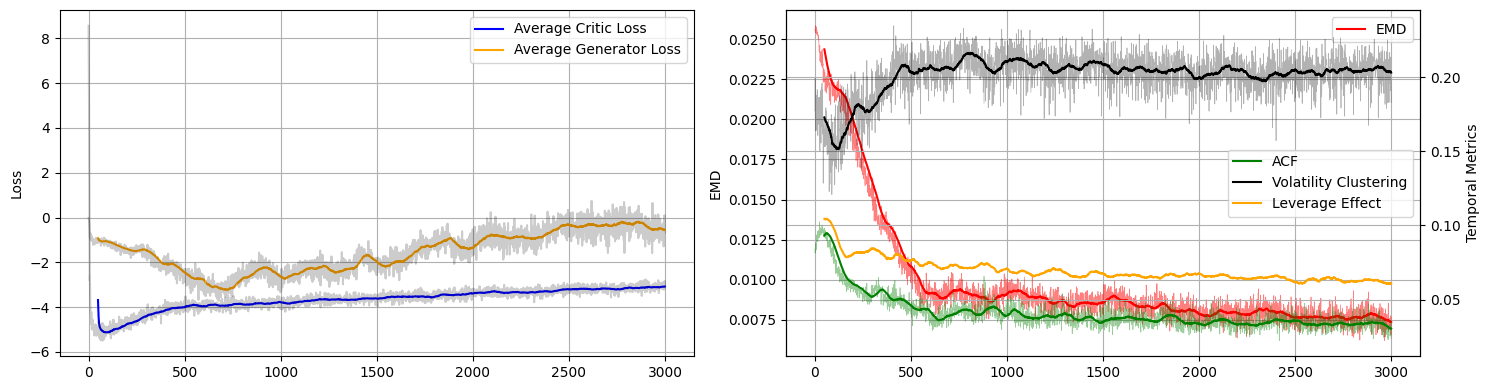

In [32]:
critic_loss = tf.squeeze(gan.critic_loss_avg, axis=(1,2)).numpy()
generator_loss = np.array(gan.generator_loss_avg)

window = 50
generator_ma = np.convolve(generator_loss, np.ones(window)/window, mode='valid')
critic_ma = np.convolve(critic_loss, np.ones(window)/window, mode='valid')

# plot the graphs side-by-side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

# plot the critic loss moving average as a line
axes[0].plot(range(window-1, len(critic_loss)), critic_ma, label='Average Critic Loss', color='blue')
# plot the critic loss
axes[0].plot(critic_loss, color='black', alpha=0.2)

# plot the generator loss moving average as a line
axes[0].plot(range(window-1, len(generator_loss)), generator_ma, label='Average Generator Loss', color='orange')
# plot the generator loss
axes[0].plot(generator_loss, color='black', alpha=0.2)


axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

emd_avg = np.array(gan.emd_avg)
emd_ma = np.convolve(emd_avg, np.ones(window)/window, mode='valid')

axes[1].plot(range(window-1, len(emd_avg)), emd_ma, label='EMD', color='red')
axes[1].plot(emd_avg, color='red', linewidth=0.5, alpha=0.5)

axes[1].set_ylabel('EMD')
axes[1].legend()
axes[1].grid()

acf_avg = np.array(gan.acf_avg)
vol_avg = np.array(gan.vol_avg)
lev_avg = np.array(gan.lev_avg)

acf_ma = np.convolve(acf_avg, np.ones(window)/window, mode='valid')
vol_ma = np.convolve(vol_avg, np.ones(window)/window, mode='valid')
lev_ma = np.convolve(lev_avg, np.ones(window)/window, mode='valid')

# Creating a twin axes for the second graph
axes2 = axes[1].twinx()

axes2.plot(range(window-1, len(acf_avg)), acf_ma, label='ACF', color='green')
axes2.plot(acf_avg, color='green', linewidth=0.5, alpha=0.4)

axes2.plot(range(window-1, len(vol_avg)), vol_ma, label='Volatility Clustering', color='black')
axes2.plot(vol_avg, color='black', linewidth=0.5, alpha=0.3)

axes2.plot(range(window-1, len(lev_avg)), lev_ma, label='Leverage Effect', color='orange')

axes2.set_ylabel('Temporal Metrics')
axes2.legend()
axes2.grid()

# Adjusting the spacing between subplots
plt.tight_layout()

## Plot Generated Data Properties

In [33]:
num_samples = len(sp500_log_r_tf) // WINDOW_SIZE
latent_noise = tf.random.normal(shape=(num_samples, LATENT_DIM))
# generate data using the generator
generated_data = gan.generator.predict(latent_noise)
generated_data = tf.reshape(generated_data, shape=(num_samples*WINDOW_SIZE,))

# reverse the preprocessing on generated series
transformed_sp500_denorm = denormalize(generated_data, tf.reduce_mean(transformed_sp500), tf.math.reduce_std(transformed_sp500))
original_norm = lambert_w_transform(transformed_sp500_denorm, 1)
fake_original = denormalize(original_norm, tf.reduce_mean(sp500_log_r_tf), tf.math.reduce_std(sp500_log_r_tf))

6/6 [==============================] - 0s 2ms/step


In [34]:
print('Min-Max values of generated data: ', tf.reduce_min(generated_data).numpy(), tf.reduce_max(generated_data).numpy())
print('Min-Max values of generated log-returns (for all batches): ', tf.reduce_min(fake_original).numpy(), tf.reduce_max(fake_original).numpy())
print('Min-Max values after Lambert: ', tf.reduce_min(original_norm).numpy(), tf.reduce_max(original_norm).numpy())

Min-Max values of generated data:  -3.7800737757195786 3.91309226140125
Min-Max values of generated log-returns (for all batches):  -0.15014752866101685 0.13795661749557228
Min-Max values after Lambert:  -12.0 11.0


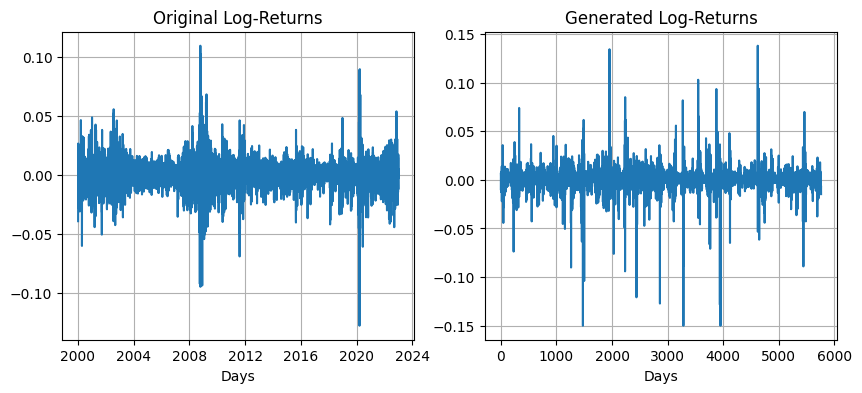

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot original log-returns on the left and the generated on the right
#
###################################################################################################################
axes[0].plot(date[1:], sp500_log_r_tf)
axes[0].set_xlabel('Days')
axes[0].set_title('Original Log-Returns')
axes[0].grid()

axes[1].plot(fake_original)
axes[1].set_xlabel('Days')
axes[1].set_title('Generated Log-Returns')
axes[1].grid()

plt.show()

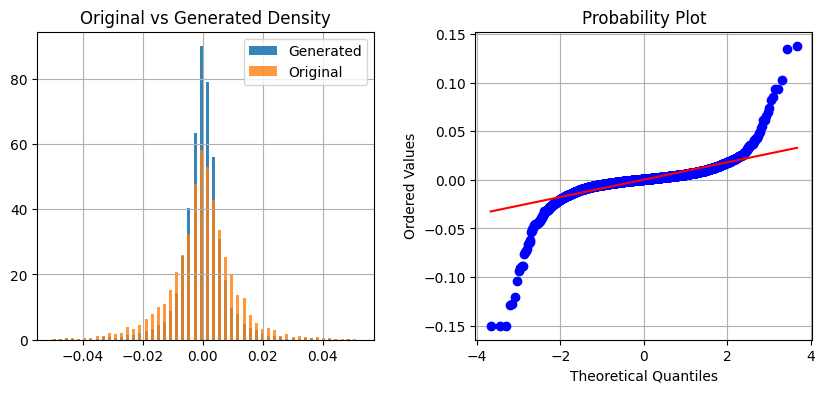

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot histogram of generated along with original log-returns on the left and the Q-Q plot on the right
#
###################################################################################################################
bin_edges = np.linspace(-0.05, 0.05, num=50)  # define the bin edges
bin_width = bin_edges[1] - bin_edges[0]
bin_edges = np.append(bin_edges, bin_edges[-1] + bin_width)
axes[0].hist(fake_original, bins=bin_edges, density=True, width=0.001, label='Generated', alpha=0.9)
axes[0].hist(sp500_log_r_tf, bins=bin_edges, density=True, width=0.001, label='Original', alpha=0.8)
axes[0].set_title('Original vs Generated Density')
axes[0].grid()
axes[0].legend()

probplot(fake_original, dist='norm', plot=axes[1])
axes[1].set_xlabel('Theoretical Quantiles')
axes[1].grid()

plt.subplots_adjust(wspace=0.3)

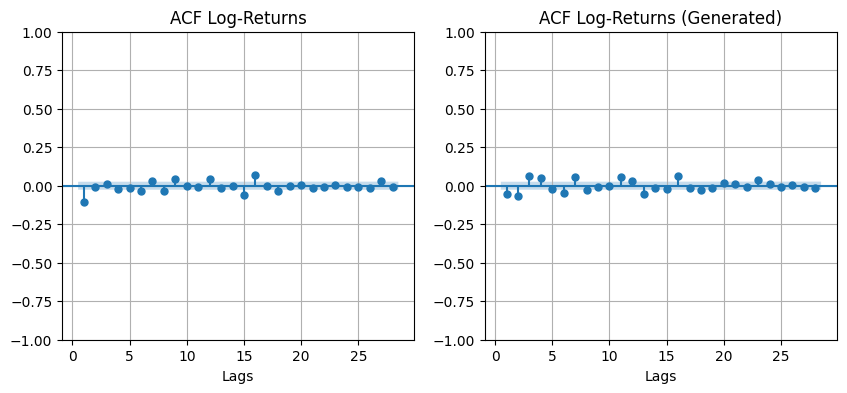

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot autocorrelations of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(sp500_log_r_tf, ax=axes[0], lags=28, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Log-Returns')
axes[0].grid()

tsaplots.plot_acf(fake_original, ax=axes[1], lags=28, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Log-Returns (Generated)')
axes[1].grid()

plt.show()

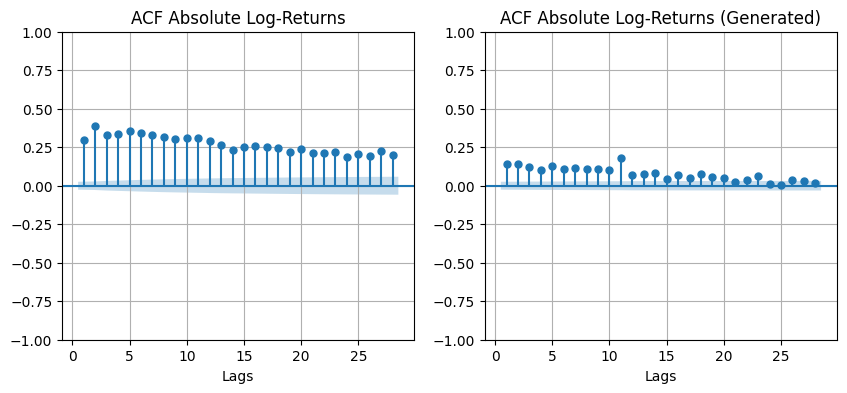

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot volatility clustering of original log-returns on the left and the generated on the right
#
###################################################################################################################
tsaplots.plot_acf(tf.abs(sp500_log_r_tf), ax=axes[0], lags=28, zero=False)
axes[0].set_xlabel('Lags')
axes[0].set_title('ACF Absolute Log-Returns')
axes[0].grid()

tsaplots.plot_acf(tf.abs(fake_original), ax=axes[1], lags=28, zero=False)
axes[1].set_xlabel('Lags')
axes[1].set_title('ACF Absolute Log-Returns (Generated)')
axes[1].grid()

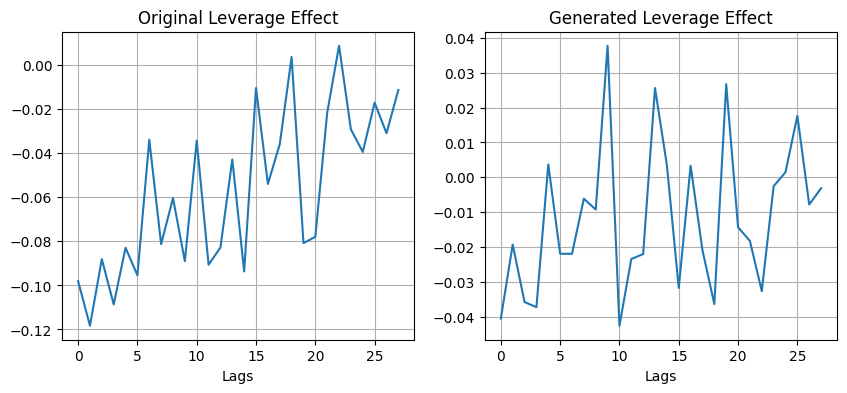

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
###################################################################################################################
#
# plot leverage effect of original log-returns on the left and the generated on the right
#
###################################################################################################################
# compute leverage effect for maximum lags = 28
leverage_original = []
for lag in range(1, 29):
    # slice the tensors to get the appropriate lagged sequences
    r_t = sp500_log_r_tf[:-lag]
    squared_lag_r = tf.square(tf.abs(sp500_log_r_tf[lag:]))
                
    # calculate the leverage effect
    leverage_original.append(tfp.stats.correlation(r_t, squared_lag_r, sample_axis=0, event_axis=None))
    
leverage_generated = []
for lag in range(1, 29):
    # slice the tensors to get the appropriate lagged sequences
    r_t = fake_original[:-lag]
    squared_lag_r = tf.square(tf.abs(fake_original[lag:]))
                
    # calculate the leverage effect
    leverage_generated.append(tfp.stats.correlation(r_t, squared_lag_r, sample_axis=0, event_axis=None))

axes[0].plot(leverage_original)
axes[0].set_xlabel('Lags')
axes[0].set_title('Original Leverage Effect')
axes[0].grid()

axes[1].plot(leverage_generated)
axes[1].set_xlabel('Lags')
axes[1].set_title('Generated Leverage Effect')
axes[1].grid()

In [40]:
gan.generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 30)                270       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 50)                2550      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 50)                0         
                                                                 
 dropout_1 (Dropout)         (None, 50)               

In [41]:
gan.critic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            704       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 30, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 128)           82048     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 128)           163968    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 30, 128)           0         
                                                                 
 flatten (Flatten)           (None, 3840)              0